# Data Organization for linArray_app

In [1]:
#load libraries
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import math
import alignment_functions as af
import PyTrack.etDataReader as et

In [ ]:
#dir( af )

In [2]:
from os import listdir
from os.path import isfile, join
mypath = "/home/bonzilla/Documents/ScienceLife/linArray/linArray_data/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print( onlyfiles )

['T35_083018_t1_spikingDAT.mat', 'T35_083018_t2_spikingDAT.mat', 'T35_083018_t2-01.plx', 'T35_083018_t2.plx', 'T35_083018_t3.plx', 'T35_083018_t1.plx', 'T35_083018_t3_spikingDAT.mat', 'T35_083018_t1-01.plx']


In [3]:
#load .mat into python environment @ new machine
chosen_data = onlyfiles[1]
linArrayPath = mypath + chosen_data
linArrayMat = loadmat( linArrayPath )
print(linArrayMat.keys())
multi_dSacctrials = af.getMultiChannelTrialData( linArrayMat, 'SPK', 'delayedSaccIntervals' )
multi_dSacctrials.shape

dict_keys(['__header__', '__version__', '__globals__', 'SPK09i', 'SPK10i', 'SPK11i', 'SPK12i', 'SPK13a', 'SPK13i', 'SPK14i', 'SPK15a', 'SPK15i', 'SPK16a', 'SPK16i', 'Start', 'Stop', 'Strobed00001', 'Strobed00003', 'Strobed00005', 'Strobed00006', 'Strobed00007', 'Strobed00009', 'Strobed00010', 'Strobed00013', 'Strobed00014', 'Strobed00016', 'Strobed00017', 'Strobed00018', 'Strobed00030', 'Strobed00040', 'Strobed00041', 'Strobed00043', 'Strobed00046', 'Strobed00050', 'Strobed00100', 'Strobed00102', 'Strobed00131', 'Strobed00161', 'Strobed00235', 'Strobed00360', 'Strobed00400', 'Strobed00555', 'Strobed00666', 'Strobed00830', 'Strobed01000', 'Strobed01618', 'Strobed01808', 'Strobed02000', 'Strobed02018', 'Strobed05555', 'catSearchPHYSIOLIntervals', 'delayedSacc180RFInt', 'delayedSaccIntervals', 'plxDataIntervals'])


(31, 13)

## Delayed Saccade

In [ ]:
multi_dSacctrials = af.getMultiChannelTrialData( linArrayMat, 'SPK', 'delayedSaccIntervals', timeint = [0., 90.] )
addStrobes = multi_dSacctrials.copy()
addStrobes = af.addEventMarker( linArrayMat, addStrobes, [ 30, 40, 555, 666, 100 ], 'delayedSaccIntervals' )

In [ ]:
# aligning neural data
stimOn = 555 #define the eventmarker for stimulus onset
multi_DSalign = af.addStimOnset( addStrobes, stimOn, 'SPK' )

In [ ]:
stimOnCols = af.getDataTypeNames( multi_DSalign, 'stimOn_' ).values.tolist()
stimOnCols = [item for sublist in stimOnCols for item in sublist]
time_axis_limits_ms = [ -50, 150 ]

In [ ]:
#load behavioral .mat into python environment
path = "/home/bonzilla/Documents/ScienceLife/linArray/bhv_083018/"

bhv_file = "180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1).mat"
bhvPath = path + bhv_file #"180830_Peanut_delayedSaccadeTask_2016_6_8(1)(1).mat" #holds 22 trials, 14 correct trials Track2 RF mapping == T35_083018_t2_delayedSaccade.pkl
#bhvPath = path + bhv_file #"180830_Peanut_delayedSaccadeTask_2016_6_8(1)(2).mat" #holds 52 trials, 41 correct trials Track2 RF+180
#bhvPath = path + bhv_file #"180830_Peanut_delayedSaccadeTask_2016_6_8(1)(3).mat" #holds 82 trials, 70 correct trials ???
#bhvPath = path + "180830_Peanut_delayedSaccadeTask_2016_6_8(1).mat" #holds 152 trials, 64 correct trials Track1?
bhvMat = loadmat( bhvPath )

In [ ]:
BHV_df = af.bhvmat2pandasdf( bhvMat )
BHV_plusEV = af.addMultiEventVariables( BHV_df, [ 30, 40, 666, 100 ] )
print( BHV_plusEV.shape )
# select just the correct trials
BHV_correct = BHV_plusEV[
    BHV_plusEV['Trial_Error']==0].reset_index()
print( BHV_correct.shape )

In [ ]:
#merging neural & behavioral data 
column_list = [ 'AnalogEyeData', 'bhv_code30', 'bhv_code40', 'bhv_code666' ]
mergedDS = af.mergeBehavioralColumn( 
    multi_DSalign, BHV_correct, column_list )
mergedDS = af.split_analog_eye( mergedDS, 'AnalogEyeData' )

In [ ]:
merged_bothAlign = af.add_saccade_onsets( mergedDS, 'bhv_code40', 'bhv_code666' )
stimOn_eyealign = af.alignments4trials( merged_bothAlign, 'bhv_code40', 'saccade_onset', 0 )
plt.show( stimOn_eyealign )

In [ ]:
merged_bothAlign = af.adjustSpikes_SaccadeStart( merged_bothAlign, 'saccade_onset', 'SPK' )

In [ ]:
combinedalign = af.eyespike_dualAligned( merged_bothAlign, 'SPK13i', 'bhv_code40', 'saccade_onset', time_axis_limits_ms, 0  )
plt.show( combinedalign )

In [ ]:
merged_bothAlign = merged_bothAlign.assign( neuralDat = chosen_data, BHVdat = bhv_file )
merged_bothAlign

In [ ]:
merged_bothAlign.to_pickle("T35_083018_t1_delayedSaccade.pkl")

In [ ]:
t1 = pd.read_pickle("T35_083018_t1_delayedSaccade.pkl")
t2 = pd.read_pickle("T35_083018_t2_delayedSaccade.pkl")
t3 = pd.read_pickle("T35_083018_t3_delayedSaccade.pkl")

ds_df = pd.concat([t1, t2, t3], ignore_index=True)
ds_df = ds_df.assign( task = 'delayed saccade' )
ds_df.shape

In [ ]:
#ds_df.to_pickle("delayedSaccade.pkl")

## catSearchPHYSIOL

In [ ]:
#load .mat into python environment @ new machine
chosen_data = onlyfiles[6]
linArrayPath = mypath + chosen_data
linArrayMat = loadmat( linArrayPath )
print(linArrayMat.keys())

# demonstrate getMultiChannelTrialData()
# generates a pandas dataframe with a row for each trial, start/end features and columns for each channeldata
catSearchtrials = af. getMultiChannelTrialData( linArrayMat, 'SPK', 'catSearchPHYSIOLIntervals' )
print( catSearchtrials.shape )
catSearchtrials.info()

In [ ]:
catSearchaddStrobes = catSearchtrials.copy()
af.addEventMarker( linArrayMat, catSearchaddStrobes, [ 1, 14, 40 ], 'catSearchPHYSIOLIntervals' )
catSearchaddStrobes.head()

In [ ]:
# aligning neural data
stimOn = 40 #define the eventmarker for stimulus onset
catSearch_multi_DSalign = af.addStimOnset( catSearchaddStrobes, stimOn, 'SPK' )

In [ ]:
stimOnCols = af.getDataTypeNames( catSearch_multi_DSalign, 'stimOn_' ).values.tolist()
stimOnCols = [item for sublist in stimOnCols for item in sublist]
print( stimOnCols )
time_axis_limits_ms = [ -50, 150 ]

In [ ]:
#load behavioral .mat into python environment
path = "/home/bonzilla/Documents/ScienceLife/linArray/bhv_083018/"
#bhv_file = "180830_Peanut_CatSearch_Physiol_ML2_2018_8_30(1).mat"
bhv_file = "180830_Peanut_CatSearch_Physiol_ML2_2018_8_30(2).mat"
bhvPath = path + bhv_file 
bhvMat = loadmat( bhvPath )

In [ ]:
BHV_df = af.catSearchPHYSIOL2pandasdf( bhvMat )
BHV_plusEV = af.addMultiEventVariables( BHV_df, [ 1, 40, 14 ] )
print( BHV_plusEV.shape )
# select just the correct trials
BHV_correct = BHV_plusEV[
    BHV_plusEV['Trial_Error']==0].reset_index()
print( BHV_correct.shape )

In [ ]:
#merging neural & behavioral data 
column_list = [ 'AnalogEyeData', 'bhv_code1', 'bhv_code40', 'bhv_code14' ]
mergedDS = af.mergeBehavioralColumn( 
    catSearch_multi_DSalign, BHV_correct, column_list )
mergedDS = af.split_analog_eye( mergedDS, 'AnalogEyeData' )

In [ ]:
catSearch_stimOn_align = af.eyespike_stimOnAligned( mergedDS, 'SPK13i', 'bhv_code40', time_axis_limits_ms, 0  )
plt.show( catSearch_stimOn_align )

In [ ]:
#print( chosen_data )
#T35_083018_t3_catSearchPHYSIOL = mergedDS
#T35_083018_t3_catSearchPHYSIOL.to_pickle("T35_083018_t3_catSearchPHYSIOL.pkl")

## delayedSaccade180

In [21]:
t1_180 = pd.read_pickle( 'T35_083018_t1_delayedSaccade180RFInt.pkl' )
print( t1_180.shape )
t1_180.info()

(21, 64)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 64 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                21 non-null     int64  
 1   start                21 non-null     float64
 2   end                  21 non-null     float64
 3   SPK01i               21 non-null     object 
 4   SPK02i               21 non-null     object 
 5   SPK03i               21 non-null     object 
 6   SPK04i               21 non-null     object 
 7   SPK05i               21 non-null     object 
 8   SPK06i               21 non-null     object 
 9   SPK07i               21 non-null     object 
 10  SPK08i               21 non-null     object 
 11  SPK09i               21 non-null     object 
 12  SPK10i               21 non-null     object 
 13  SPK11i               21 non-null     object 
 14  SPK12i               21 non-null     object 
 15  SPK13i               21 non-null 

In [22]:
t2_180 = pd.read_pickle( 'T35_083018_t2_delayedSaccade180RFInt.pkl' )
print( t2_180.shape )
t2_180.info()

(41, 50)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   level_0              41 non-null     int64  
 1   index                41 non-null     int64  
 2   start                41 non-null     float64
 3   end                  41 non-null     float64
 4   SPK09i               41 non-null     object 
 5   SPK10i               41 non-null     object 
 6   SPK11i               41 non-null     object 
 7   SPK12i               41 non-null     object 
 8   SPK13a               41 non-null     object 
 9   SPK13i               41 non-null     object 
 10  SPK14i               41 non-null     object 
 11  SPK15a               41 non-null     object 
 12  SPK15i               41 non-null     object 
 13  SPK16a               41 non-null     object 
 14  SPK16i               41 non-null     object 
 15  Strobed00030         41 non-null 

In [70]:
# new plotfunction to show in vs out trials
import matplotlib.patches as mpatches

# a simple plot of instantaneous firing rate
def channelGaussianSmoothed_180( df_in, df_out, channel, sigma, time_axis_limits_ms ):
    """
    Takes in a spiketrain (list of spike times) and returns a smooth firing 
    rate estimate that does not rely on binnning of a spie train. the instantaneous rate
    isa convolution of the spiketrain with a firing rate kernel
    """
    from scipy.ndimage import gaussian_filter1d
    
    # df_in
    num_trials = df_in.shape[0]
    spiketrain = df_in[channel].sum()
    b = np.arange(time_axis_limits_ms[0], time_axis_limits_ms[1], 1)
    (counts, bins) = np.histogram(spiketrain, bins=b)
    plt.hist(bins[:-1], bins, weights=counts/num_trials, 
             color = [0.40, 0.10, 0.10 ],
             alpha=0.5)
    smoothedSpikes = gaussian_filter1d(counts/num_trials, sigma)
    plt.plot( bins[:-1], smoothedSpikes, lw = 2, color = 'r' )
    
    #df_out
    num_trials = df_out.shape[0]
    spiketrain = df_out[channel].sum()
    b = np.arange(time_axis_limits_ms[0], time_axis_limits_ms[1], 1)
    (counts, bins) = np.histogram(spiketrain, bins=b)
    plt.hist(bins[:-1], bins, weights=counts/num_trials, 
             color = [0.1, 0.4, 0.1 ],
             alpha=0.5)
    smoothedSpikes = gaussian_filter1d(counts/num_trials, sigma)
    plt.plot( bins[:-1], smoothedSpikes, lw = 2, color = 'g' )
    
    red_patch = mpatches.Patch(color='red', label='in RF')
    green_patch = mpatches.Patch(color='green', label='out RF')
    plt.legend(handles=[red_patch, green_patch])
    plt.xlim(time_axis_limits_ms)           
    plt.ylabel('spikes/ms')
    plt.xlabel("time (ms)")
    plt.title(channel)             
    plt.axvline(x=0, c = 'k')    

# a simple plot of instantaneous firing rate
def saccadeStart_GaussianSmoothed_180( df_in, df_out, channel, sigma, time_axis_limits_ms ):
    """
    Takes in a spiketrain (list of spike times) and returns a smooth firing 
    rate estimate that does not rely on binnning of a spie train. the instantaneous rate
    isa convolution of the spiketrain with a firing rate kernel
    """
    from scipy.ndimage import gaussian_filter1d
    
    # in RF
    num_trials = df_in.shape[0]
    b = np.arange(time_axis_limits_ms[0], time_axis_limits_ms[1], 1)
    neuralData = df_in[channel].sum()      
    (counts, bins) = np.histogram(neuralData, bins=b)
    plt.hist(bins[:-1], bins, weights=counts/num_trials, 
             color = [0.4, 0.1, 0.1 ],
             alpha=0.5)
    smoothedSpikes = gaussian_filter1d(counts/num_trials, sigma)
    plt.plot( bins[:-1], smoothedSpikes, lw = 2, color = 'r', label='in RF' )
    
    # out RF
    num_trials = df_out.shape[0]
    b = np.arange(time_axis_limits_ms[0], time_axis_limits_ms[1], 1)
    neuralData = df_out[channel].sum()      
    (counts, bins) = np.histogram(neuralData, bins=b)
    plt.hist(bins[:-1], bins, weights=counts/num_trials, 
             color = [0.1, 0.4, 0.1 ],
             alpha=0.5)
    smoothedSpikes = gaussian_filter1d(counts/num_trials, sigma)
    plt.plot( bins[:-1], smoothedSpikes, lw = 2, color = 'g', label='out RF' )    
    
    plt.xlim(time_axis_limits_ms)            
    plt.ylabel('spikes/ms')  
    plt.xlabel("time (ms)")
    plt.title(channel)             
    plt.axvline(x=0, c = 'k')    

def eyespike_dualAligned_180( df, channel, stimon_marker, saccadeinit_marker, time_axis_limits_ms, trial_start, trial_stop=-1 ):
    """
    for delayed saccade 180
    subplot X,Y analog eye-traces and smoothed spike histograms
    for a given range of trials (trial_start, trial_stop):
    plot1 = stimOn spikes align
    plot2 = saccade spikes align
    plot3 = stimOn eye align
    plot4 = saccade eye align
    """
    df_inRF = df[df['inRF']==True].reset_index(drop=True)
    df_outRF = df[df['inRF']==False].reset_index(drop=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 10))
    
    plt.subplot( 2,2,3 )
    stimOn_label = 'stimOn_' + channel
    channelGaussianSmoothed_180( df_inRF, df_outRF, stimOn_label, 10, time_axis_limits_ms )

    
    plt.subplot( 2,2,4 )
    saccadeStart_label = 'saccadeStart_' + channel
    saccadeStart_GaussianSmoothed_180( df_inRF, df_outRF, saccadeStart_label, 10, time_axis_limits_ms )
    
    plt.subplot( 2,2,1 )
    for idx,_ in enumerate( df_inRF['AnalogEyeData'][trial_start:trial_stop] ):
        length = len( df_inRF['AnalogEyeData'][trial_start + idx] )
        x =  np.arange( 0, length ) - df_inRF[stimon_marker][trial_start + idx][0]
        plt.plot(x, df_inRF['X_eye'][trial_start + idx], color = 'red')
        plt.plot(x, df_inRF['Y_eye'][trial_start + idx], color = 'red')
    for idx,_ in enumerate( df_outRF['AnalogEyeData'][trial_start:trial_stop] ):
        length = len( df_outRF['AnalogEyeData'][trial_start + idx] )
        x =  np.arange( 0, length ) - df_outRF[stimon_marker][trial_start + idx][0]
        plt.plot(x, df_outRF['X_eye'][trial_start + idx], color = 'green')
        plt.plot(x, df_outRF['Y_eye'][trial_start + idx], color = 'green')
    
    red_patch = mpatches.Patch(color='red', label='in RF')
    green_patch = mpatches.Patch(color='green', label='out RF')
    plt.legend(handles=[red_patch, green_patch])
    plt.axvline( x=0, color = 'black'  )
    plt.ylabel( 'Saccade Amplitude (DVA)' )
    plt.title( 'Stimulus Onset' )
    plt.xlim( time_axis_limits_ms )  
    
    plt.subplot( 2,2,2 )
    for idx,_ in enumerate( df_inRF['AnalogEyeData'][trial_start:trial_stop] ):
        length = len( df_inRF['AnalogEyeData'][trial_start + idx] )
        x =  np.arange( 0, length ) - df_inRF[saccadeinit_marker][trial_start + idx][0] - df_inRF[stimon_marker][trial_start + idx][0]
        plt.plot(x, df_inRF['X_eye'][trial_start + idx], color = 'red')
        plt.plot(x, df_inRF['Y_eye'][trial_start + idx], color = 'red')
    for idx,_ in enumerate( df_outRF['AnalogEyeData'][trial_start:trial_stop] ):
        length = len( df_outRF['AnalogEyeData'][trial_start + idx] )
        x =  np.arange( 0, length ) - df_outRF[saccadeinit_marker][trial_start + idx][0] - df_outRF[stimon_marker][trial_start + idx][0]
        plt.plot(x, df_outRF['X_eye'][trial_start + idx], color = 'green')
        plt.plot(x, df_outRF['Y_eye'][trial_start + idx], color = 'green')        
    plt.title( 'Saccade Onset' )
    plt.axvline( x=0, color = 'black'  )
    plt.xlim( time_axis_limits_ms )
    
    return fig

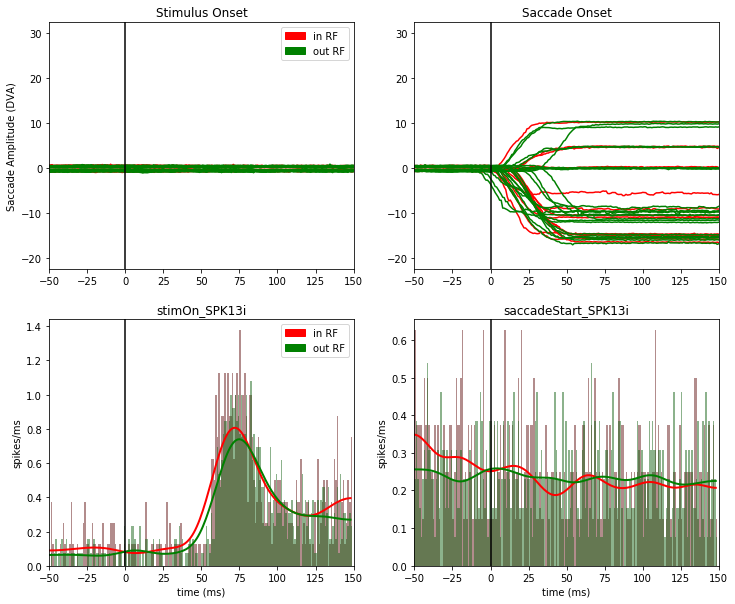

In [71]:
time_axis_limits_ms = [ -50, 150 ]
attempt = eyespike_dualAligned_180( t1_180, 'SPK13i', 'bhv_code40', 'saccade_onset', time_axis_limits_ms, 0  )
plt.show( attempt )